# Naive Bayes Classifier with Kernel Density Estimators

The following code trains a Naive Bayes Classifier with KDEs to predict the distance between the Raspberrry Pis. The code below is adapted from Chapter 5 of Jake VanderPlas' *Python Data Science Handbook* and utilizes the `KDECLassifier` class from the same source.

In [1]:
# Config
from pi_pact_sort import categorize, bin_categorize

FEATURES: list = ['RSSI', 'PRESSURE']
CATEGORIZE_FUNC = bin_categorize

if len(FEATURES) > 0:
    if len(FEATURES) == 1:
        if 'HUMIDITY' in FEATURES:
            feature_str = '3varH'
        else:
            feature_str = '3varP'
    else:
        feature_str = '4var'
else:
    feature_str = '2var'

if CATEGORIZE_FUNC == categorize:
    label_str = '3b'
else:
    label_str = 'binary'

In [2]:
from kde_classifier import KDEClassifier
import pandas as pd
from pathlib import Path
import pickle
import numpy as np
from sklearn.model_selection import GridSearchCV

DROP_COLUMNS = ['ADDRESS', 'TIMESTAMP', 'UUID', 'MAJOR', 'MINOR', 'TX POWER', 'TEMPERATURE',
                'PITCH', 'ROLL', 'YAW', 'SCAN']
for feature in ['RSSI', 'HUMIDITY', 'PRESSURE']:
    if feature not in FEATURES:
        DROP_COLUMNS.append(feature)
SAMPLE_SIZE = 30000
np.random.seed(0)


"""Creates a Naive Bayes classifier with KDE to predict a distance range given RSSI values and other variables.

   KDEClassifier class adapted from Chapter 5 of the Python Data Science Handbook by Jake VanderPlas:
   https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
"""

# Initialize DataFrame
data: pd.DataFrame = pd.DataFrame(columns=['DISTANCE',] + FEATURES)
data_copy: pd.DataFrame = data.copy()
csv_file: Path
for csv_file in Path('.').glob('indoor-noObstruct-SenseHat*/*.csv'):
    datapart: pd.DataFrame = pd.read_csv(csv_file)
    for column in DROP_COLUMNS:
        if column in datapart.columns:
            datapart = datapart.drop([column], 1)
    data_copy = data_copy.append(datapart)

# Categorize distance
data_copy['DISTANCE'] = data_copy['DISTANCE'].map(CATEGORIZE_FUNC)

# Sample data from each distance category
for value in data_copy['DISTANCE'].unique():
    datapart = data_copy[data_copy.DISTANCE == value]
    datapart = datapart.sample(SAMPLE_SIZE, random_state=1)
    data = data.append(datapart)

# Assign features and labels
X: np.array = data.drop(['DISTANCE'], 1).to_numpy()
y: np.array = data['DISTANCE'].to_numpy(dtype=int)

# Hyperparameter tuning
# Code adapted from Chapter 5 of the Python Data Science Handbook by Jake VanderPlas:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
bandwidths = np.around(np.linspace(0.5, 1, 5), decimals=4)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, n_jobs=1)
grid.fit(X, y)

GridSearchCV(estimator=KDEClassifier(), n_jobs=1,
             param_grid={'bandwidth': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])})

In [3]:
print(grid.best_params_)
print('accuracy =', grid.best_score_)

{'bandwidth': 0.5}
accuracy = 0.9615166666666667


In [4]:
with open(f"nb-kde-models/{feature_str}-{label_str}-nb-kde-model.pickle", "wb") as f:
    pickle.dump(grid.best_estimator_, f)

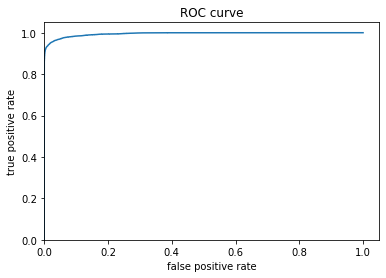

In [5]:
%matplotlib inline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

if CATEGORIZE_FUNC == bin_categorize:
    probs = grid.best_estimator_.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, probs[:, 1])
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.savefig(str(Path(f'./nb-kde-models/{feature_str}-{label_str}-nb-kde-model-roc-curve.png')))